# Overview

The purpose of this case is to classify customers using transactional data to create Recency, Frequency, Monetary and Lifetime Value. These four metrics will be used as dimensions for KMeans algorithm to define customer segments, for better customer relationship management.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans

In [ ]:
data = pd.read_excel('OnlineRetail.xlsx')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
print(data.shape)
print(data.info)

(541909, 8)
<bound method DataFrame.info of        InvoiceNo StockCode  ... CustomerID         Country
0         536365    85123A  ...    17850.0  United Kingdom
1         536365     71053  ...    17850.0  United Kingdom
2         536365    84406B  ...    17850.0  United Kingdom
3         536365    84029G  ...    17850.0  United Kingdom
4         536365    84029E  ...    17850.0  United Kingdom
...          ...       ...  ...        ...             ...
541904    581587     22613  ...    12680.0          France
541905    581587     22899  ...    12680.0          France
541906    581587     23254  ...    12680.0          France
541907    581587     23255  ...    12680.0          France
541908    581587     22138  ...    12680.0          France

[541909 rows x 8 columns]>


Some quick insights:
- There is roughly half a million records with 7 columns.
- The data are based on transactions, where each row is a transaction (InvoiceNo), product (StockCode) pair.
- This pair is the pk, in addition to it there is quantity, price and date info, which is constant across all transactions. 
- There is also country of order and product description.

In [ ]:
data_no_dup=data[['Country','CustomerID']].drop_duplicates()
country_count = data_no_dup.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)
country_count.columns = ['Country', 'Number of Customers']
country_count

,Country,Number of Customers
36,United Kingdom,3950
14,Germany,95
13,France,87
31,Spain,31
3,Belgium,25
33,Switzerland,21
27,Portugal,19
19,Italy,15
12,Finland,12
1,Austria,11


- UK has majority of cases.
- There are 4 'unspecified' cases.

In [ ]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

- CustomerID has 135080 missing values and description has 1454.
- CustomerID is an issue, description not as much.


# Data Preprocessing

In [ ]:
data_copy = data.copy()
data_copy.dropna(inplace=True)
data_copy.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [ ]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


Explore any unusualities in numerical variables

In [ ]:
num_vars = []
for n in data_copy.columns:
    if data_copy[n].dtype in ['int64', 'float64']:
        num_vars.append(n)
num_vars

['Quantity', 'UnitPrice', 'CustomerID']

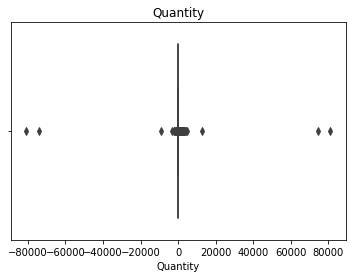

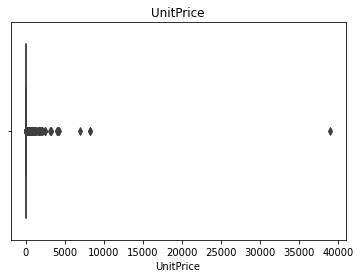

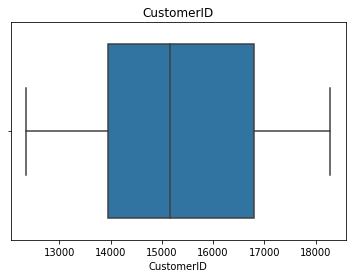

In [ ]:
import seaborn as sns

for n in num_vars:
    plt.title(n)
    sns.boxplot(x=data_copy[n])
    plt.show()

In [ ]:
data_copy.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


Clearly Quantity has negative values, probably due to returns.

In [ ]:
NegativeQuantity_tansactions = data_copy.query('Quantity < 0')[['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']]

In [ ]:
NegativeQuantity_tansactions

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


- Upon further inspection these values will be analyzed and removed from the data if a certain condition is met.
- This condition is if the Monetary column is net negative


In [ ]:
data_copy['InvoiceDate'] = pd.to_datetime(data_copy['InvoiceDate'])

In [ ]:
data_copy['TotalAmount'] = data_copy['Quantity'] * data_copy['UnitPrice']

- Creation of the TotalAmount column allows tracking of quantity leveling and removing possible outliers (ie. transactions that started in previous time period).


## RFMLt Modelling

1. Recency = Latest Date - Last Inovice Date
2. Frequency = Count of invoice no. of transaction(s)
3. Monetary = Sum of TotalAmount for each customer
4. Lifetime = Latest Date - First Invoice Date


In [ ]:
latest_date = data_copy['InvoiceDate'].max()
latest_date

Timestamp('2011-12-09 12:50:00')

In [ ]:
## Since we will have two features that use InvoiceDate, two are included.
data_copy['InvoiceDate2'] = data_copy['InvoiceDate']

In [ ]:
RFMTl = data_copy.groupby('CustomerID').agg({'InvoiceDate': lambda x: (latest_date - x.max()).days,
                          'InvoiceNo': lambda x: len(x.unique()),
                          'TotalAmount': lambda x: x.sum(),
                          'InvoiceDate2': lambda x: (latest_date - x.min()).days})


In [ ]:
RFMTl['InvoiceDate'] = RFMTl['InvoiceDate'].astype(int)
RFMTl['InvoiceDate2'] = RFMTl['InvoiceDate2'].astype(int)

RFMTl.rename(columns={'InvoiceDate': 'Recency',
                     'InvoiceNo': 'Frequency',
                     'TotalAmount': 'Monetary',
                     'InvoiceDate2': 'Lifetime'}, inplace=True)


In [ ]:
RFMTl.head()

,Recency,Frequency,Monetary,Lifetime
CustomerID,,,,
12346.0,325,2,0.00,325
12347.0,1,7,4310.00,366
12348.0,74,4,1797.24,357
12349.0,18,1,1757.55,18
12350.0,309,1,334.40,309


Lets look for monetary net negatives

In [ ]:
monetar_net_negative = RFMTl.query('Monetary < 0')[['Recency','Frequency','Monetary','Lifetime']]
monetar_net_negative

,Recency,Frequency,Monetary,Lifetime
CustomerID,,,,
12454.0,52,2,-5.684342e-14,55
12503.0,337,1,-1.126000e+03,337
12505.0,300,1,-4.500000e+00,300
12605.0,364,1,-7.500000e+00,364
12666.0,358,1,-2.274400e+02,358
12870.0,365,1,-1.490000e+01,365
12943.0,300,1,-3.750000e+00,300
13154.0,143,1,-6.118600e+02,143
13672.0,300,6,-7.146000e+01,333


In [ ]:
## Check a couple instances to see their net negative transaction history
z_check17448 = data_copy.query('CustomerID == 17448')[['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country', 'TotalAmount']]
z_check17603 = data_copy.query('CustomerID == 17603')[['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country', 'TotalAmount']]

In [ ]:
z_check17448.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
268027,C560372,M,Manual,-1,2011-07-18 12:26:00,4287.63,17448.0,United Kingdom,-4287.63


In [ ]:
z_check17603.head(20)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
122282,C546859,M,Manual,-102,2011-03-17 14:39:00,5.45,17603.0,United Kingdom,-555.90
269176,C560435,M,Manual,-1,2011-07-18 16:01:00,294.92,17603.0,United Kingdom,-294.92
269177,C560436,M,Manual,-1,2011-07-18 16:04:00,705.45,17603.0,United Kingdom,-705.45
354250,567868,84949,SILVER HANGING T-LIGHT HOLDER,6,2011-09-22 14:18:00,1.65,17603.0,United Kingdom,9.90
354251,567868,22655,VINTAGE RED KITCHEN CABINET,2,2011-09-22 14:18:00,125.00,17603.0,United Kingdom,250.00
354252,567868,23396,LA JARDIN BOTANIQUE CUSHION COVER,4,2011-09-22 14:18:00,3.75,17603.0,United Kingdom,15.00
354253,567868,23395,BELLE JARDINIERE CUSHION COVER,4,2011-09-22 14:18:00,3.75,17603.0,United Kingdom,15.00
354254,567868,23513,EMBROIDERED RIBBON REEL SUSIE,6,2011-09-22 14:18:00,2.08,17603.0,United Kingdom,12.48
354255,567868,23511,EMBROIDERED RIBBON REEL EMILY,6,2011-09-22 14:18:00,2.08,17603.0,United Kingdom,12.48
354256,567868,23515,EMBROIDERED RIBBON REEL DAISY,6,2011-09-22 14:18:00,2.08,17603.0,United Kingdom,12.48


All 44 cases will be treated as outliers as from data it cannot be inferred how a previous period transaction impacts the current period transactions; ie. there was a purchase in the previous and a return in current period


In [ ]:
RFMTl.drop(RFMTl[RFMTl.Monetary < 0].index,inplace=True)
RFMTl.shape

(4328, 4)

In [ ]:
## There are three cases where Monetary had numbers small but not equal to 0
## This function converts them to 0.
def close_to_0(num):
    """
    take a float and if it is less than 1, convert to 0
    """
    if num < 1:
        return 0
    else:
        return num

RFMTl['Monetary'] = [close_to_0(x) for x in RFMTl.Monetary]


## Correlation, distributions, outliers

In [ ]:
RFMTl.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4328 entries, 12346.0 to 18287.0
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    4328 non-null   int64  
 1   Frequency  4328 non-null   int64  
 2   Monetary   4328 non-null   float64
 3   Lifetime   4328 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 169.1 KB


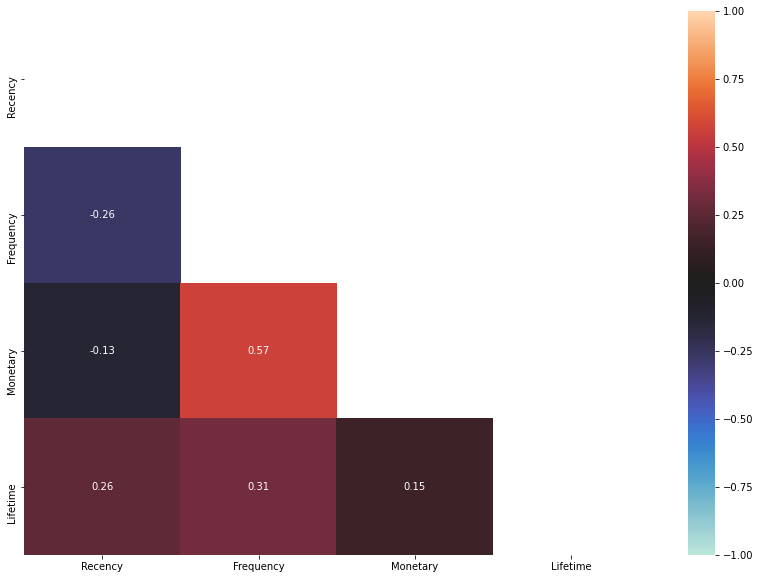

In [ ]:
corrmatrix = RFMTl.corr()
f, ax = plt.subplots(figsize=(14,10))
mask = np.zeros(corrmatrix.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True
corg = sns.heatmap(corrmatrix, vmax=1, vmin=-1, annot=True, center = 0, mask = mask)


No particular intercorrelated variables.

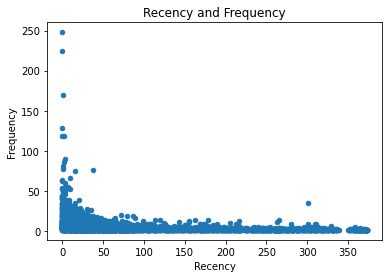

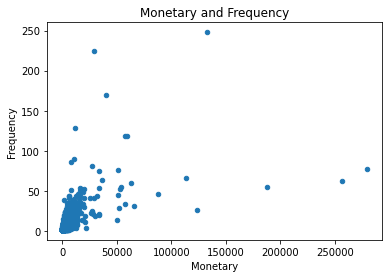

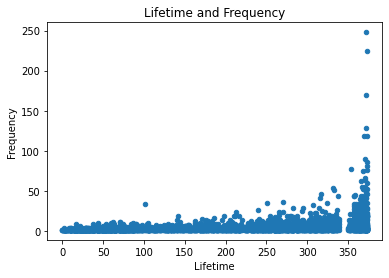

In [ ]:
for n in RFMTl.columns:
    if n != 'Frequency':
        var = n
        dat = pd.concat([RFMTl['Frequency'],RFMTl[var]], axis=1)
        dat.plot.scatter(x=var, y='Frequency')
        plt.title(str(n) + " and Frequency")
        plt.show()


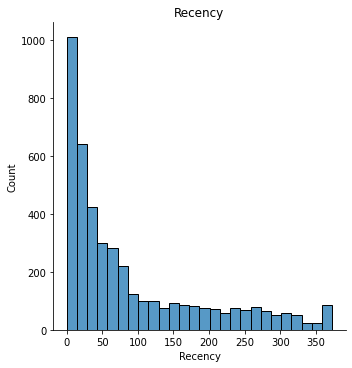

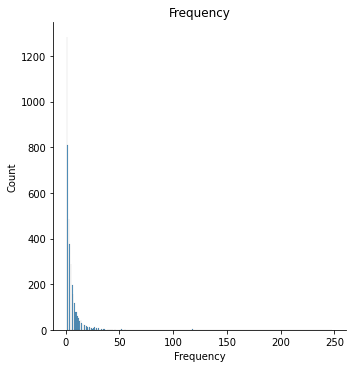

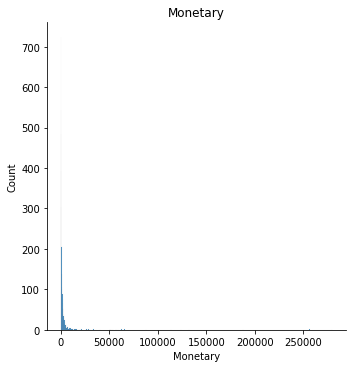

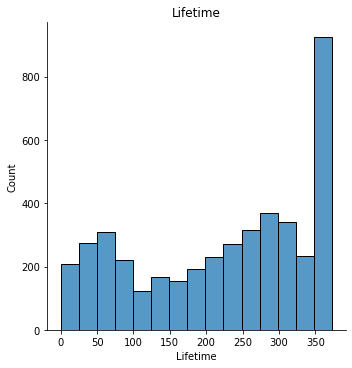

In [ ]:
for n in RFMTl.columns:
    sns.displot(RFMTl[n])
    plt.title(n)
    plt.show()

- The distributions show values that are expected and/or possible. There are no non-accounted for outliers in the current dataset.


Skewed data:
- Transform data to reduce skewness in an attempt to develop an association
- Do this by taking the log
- Before applying the logistic transformation the values that are zero must be converted to 1, because the log of 0 is -infinity -- float inf cannot be converterd to int (another options is just taking the 3 root from the number, but log will do)


In [ ]:
def negative_and_zero(num):
    """
    takes a number that is less than or equal to zero and 
    returns 1 for that number.
    """
    if num <= 0:
        return 1
    else:
        return num

In [ ]:
for n in RFMTl.columns:
    RFMTl[n] = [negative_and_zero(x) for x in RFMTl[n]]


## Pipeline Trial

Construct a pipeline that will apply the log transformation, followed by the RobustScaler to standardize data.
- RobustScaler makes more sense than StandardScaler as the data is not normally distributed.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from imblearn.pipeline import Pipeline

def log_transform(x):
    """
    returns the log of value x
    """
    return np.log(x)

transformer = FunctionTransformer(log_transform)
scaler = RobustScaler()

transformation_pipeline = Pipeline(steps=[('transformer', transformer),
                                          ('scaler', scaler)])

transformation_pipeline.fit_transform(RFMTl)


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


array([[ 0.88107095, -0.22629439, -3.85010569,  0.23737515],
       [-1.81234722,  0.47288594,  1.11633438,  0.34823417],
       [ 0.19197462,  0.16055842,  0.59724803,  0.32500245],
       ...,
       [-0.90617361,  0.        , -0.77963811, -0.65420564],
       [-1.30074423,  0.93426404,  0.68819147,  0.26843405],
       [-0.07178506,  0.        ,  0.61032425, -0.21099483]])

In [ ]:
type(transformation_pipeline)

imblearn.pipeline.Pipeline

In [ ]:
RFMTl.head()

,Recency,Frequency,Monetary,Lifetime
CustomerID,,,,
12346.0,325,2,1.00,325
12347.0,1,7,4310.00,366
12348.0,74,4,1797.24,357
12349.0,18,1,1757.55,18
12350.0,309,1,334.40,309


## Regular transformations
Pipeline proved not to be ideal for KMeans as we don't know the ideal number of clusters, might revisit later.

In [ ]:
## Apply logistic transformation
RFMTl_log_df = RFMTl[['Recency', 'Frequency', 'Monetary','Lifetime']].apply(np.log, axis = 1).round(3)

In [ ]:
## Scaling data
Scaler = RobustScaler()
scaled_data = scaler.fit_transform(RFMTl_log_df)
Scaled_Data = pd.DataFrame(scaled_data, index = RFMTl.index, columns = RFMTl_log_df.columns)

In [ ]:
Scaled_Data.head()

,Recency,Frequency,Monetary,Lifetime
CustomerID,,,,
12346.0,0.881230,-0.226562,-3.849577,0.237873
12347.0,-1.812762,0.472656,1.116452,0.348881
12348.0,0.191896,0.160156,0.597241,0.325560
12349.0,-0.466698,-0.613281,0.584186,-2.461754
12350.0,0.857476,-0.613281,-0.400831,0.190299


# Modeling

In [ ]:
sum_of_sq_dist = {}
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(Scaled_Data)
    sum_of_sq_dist[k] = km.inertia_

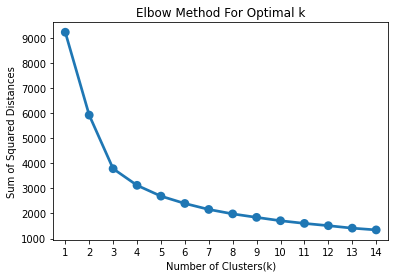

In [ ]:
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### My attempt to find the optimal number of clusters - algorithmically 
Based on the the elbow rule, the number is three, but here is an attempt to create a funciton that will find the number for me. 

In [ ]:
def optimal_clusters(d):
    """
    the overall goal of this function is to find the optimal number of clusters
    that the data provided should have. 
    This is found using the elbow rule, that is the point after which the sum of
    squared distances abruptly stops decreasing, by a large amount.
    This will be found by locating the second last value above a threshold. 
    The threshold is the average of the differences between each cluster's 
    sum of squared distances. The second last value is chosen because we offset
    the cluster values by 1, as the key, value in the dictionary used indicates,
    the the destination cluster, not the origin.
    1. First step:
    takes a dictionary with the key (#clusters): value (
    sum of squared distances) and returns the key with its difference
    from the previous sum of squared distances.
    ex: 
    {   1: 9233.026215260757,
        2: 5926.470552827595,
        3: 3786.6321999641223
    }
    would result in: 
    {   1: 0 ## as it is origin point
        2: 9233.026215260757 - 5926.470552827595 
        3: 5926.470552827595 - 3786.6321999641223
    }
    At the same time, a threshold is being created. The distance differences are
    being accumulated. 
    The optimal number of clusters will be above this threshold.
    2. Second step:
    At this stage of the function, the sum of distance differences is calculated.
    3. Third step:
    Following this in the later portion of the function, we iterate through the 
    key value pairs in the new dictionary that has the distance differences, 
    if the value for the key in the dictionary is greater than or equal to the 
    threshold, we append the value to the accumulator list.
    Finally, we take the second last value from this list, as this is where the
    elbow in the curve is. 
    """
    # return {} #stub
    # output_dict is the accumulator
    output_dict = {}
    # threshold is the average of all of the distance changes between #clusters
    sum = 0
    for n in range(len(d)):
        if n == 1:
            output_dict[n] = 0
        else:
            for cluster, distance in d.items():
                if n == cluster:
                    output_dict[n] = d[n-1] - d[n]
                    sum = sum + output_dict[n]
    # loc is accumulating list for #clusters > threshold
    loc = []
    threshold=sum/(len(d)-1)
    for cluster, distance_change in output_dict.items():
        if distance_change >= threshold:
            loc.append(cluster)

    return loc[-2]

In [ ]:
optimal_clusters(sum_of_sq_dist)

3

## Modeling with ideal number of clusters

In [ ]:
KMean_cluster = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 1000)
KMean_cluster.fit(Scaled_Data)

RFMTl['Cluster'] = KMean_cluster.labels_

colors = ["red", "yellow", "blue", ]
RFMTl['Color'] = RFMTl['Cluster'].map(lambda p: colors[p])


In [ ]:
RFMTl['Cluster'].value_counts()

2    1800
1    1574
0     954
Name: Cluster, dtype: int64

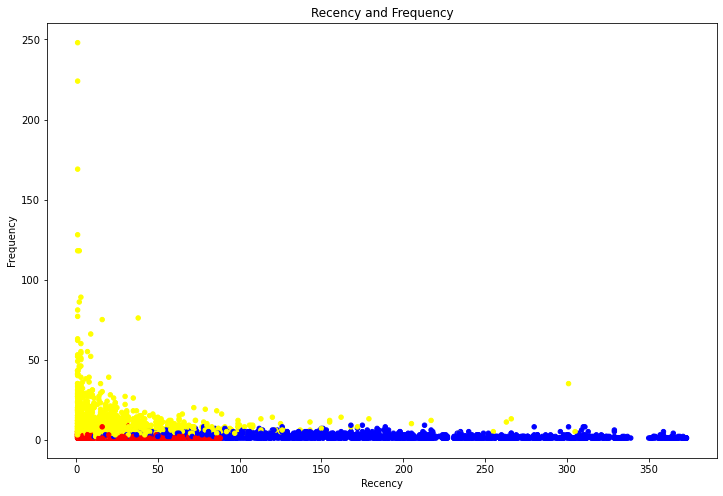

In [ ]:
##Scatter Plot Frequency Vs Recency

ax = RFMTl.plot(
    kind="scatter",
    x="Recency", y="Frequency",
    title = 'Recency and Frequency',
    figsize=(12,8),
    c = RFMTl['Color']
)

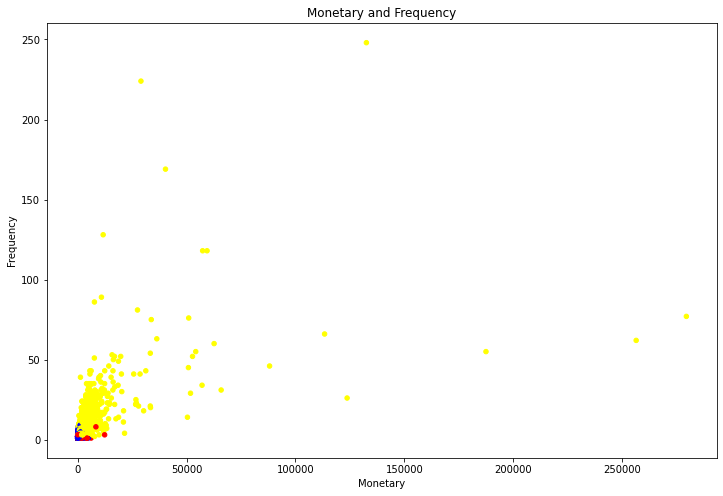

In [ ]:
ax = RFMTl.plot(
    kind="scatter",
    x="Monetary", y="Frequency",
    title = 'Monetary and Frequency',
    figsize=(12,8),
    c = RFMTl['Color']
)

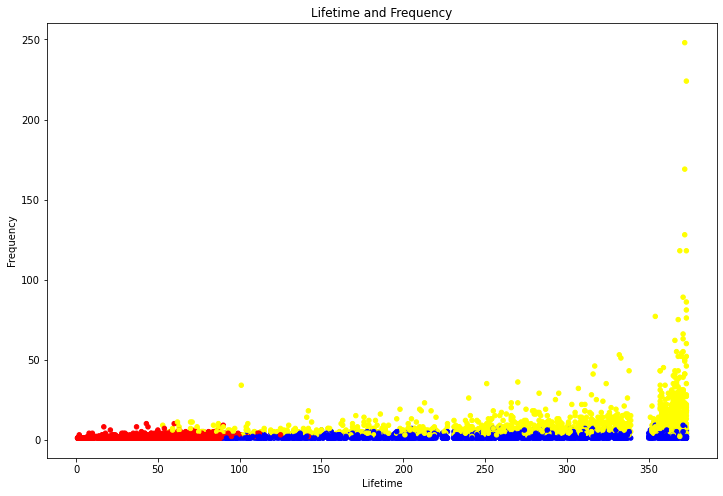

In [ ]:
ax = RFMTl.plot(
    kind="scatter",
    x="Lifetime", y="Frequency",
    title = 'Lifetime and Frequency',
    figsize=(12,8),
    c = RFMTl['Color']
)

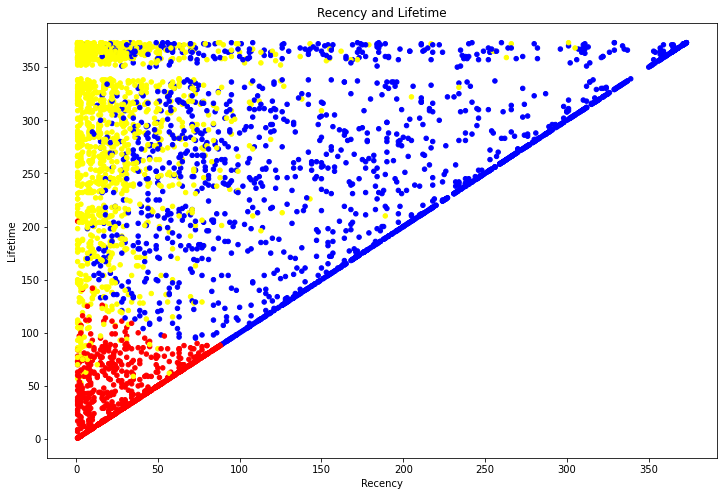

In [ ]:
ax = RFMTl.plot(
    kind="scatter",
    x="Recency", y="Lifetime",
    title= 'Recency and Lifetime',
    figsize=(12,8),
    c = RFMTl['Color']
)

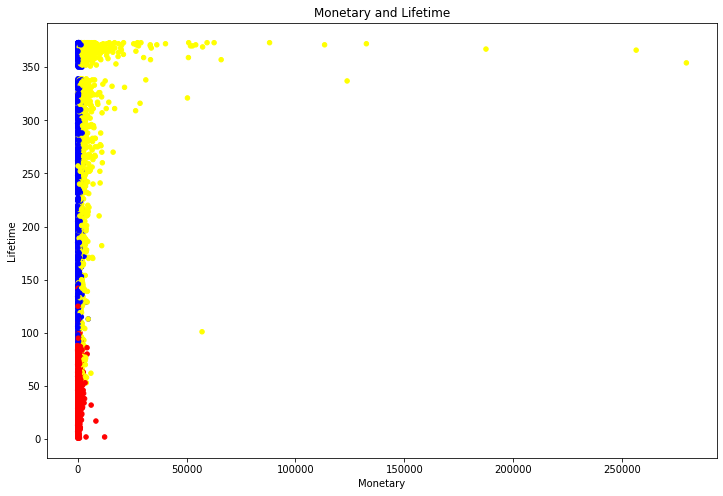

In [ ]:
ax = RFMTl.plot(
    kind="scatter",
    x="Monetary", y="Lifetime",
    title = 'Monetary and Lifetime',
    figsize=(12,8),
    c = RFMTl['Color']
)

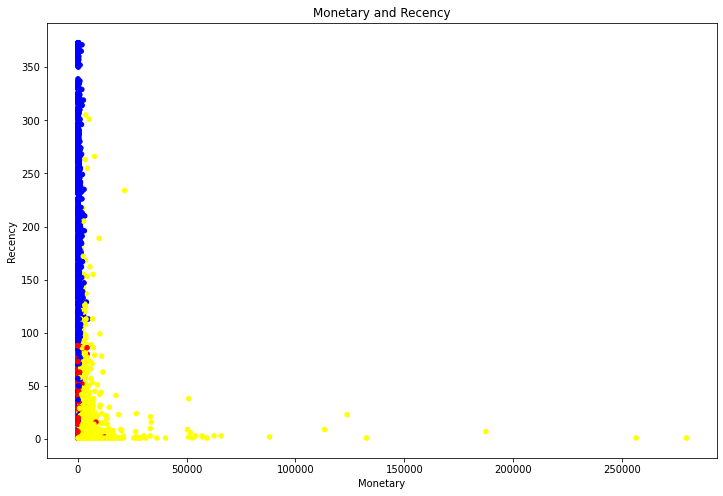

In [ ]:
ax = RFMTl.plot(
    kind="scatter",
    x="Monetary", y="Recency",
    title='Monetary and Recency',
    figsize=(12,8),
    c = RFMTl['Color']
)

# Evaluation of Customer Segments

In [ ]:
for n in range(3):
    print(RFMTl.query('Cluster =='+str(n))[RFMTl.columns].describe())

          Recency   Frequency      Monetary    Lifetime  Cluster
count  954.000000  954.000000    954.000000  954.000000    954.0
mean    35.206499    1.718029    522.597758   49.080713      0.0
std     24.636376    1.164871    688.327914   26.540527      0.0
min      1.000000    1.000000      1.000000    1.000000      0.0
25%     15.000000    1.000000    198.105000   28.000000      0.0
50%     30.000000    1.000000    354.840000   49.000000      0.0
75%     55.000000    2.000000    648.007500   70.000000      0.0
max     89.000000   10.000000  12393.700000  205.000000      0.0
           Recency    Frequency       Monetary    Lifetime  Cluster
count  1574.000000  1574.000000    1574.000000  1574.00000   1574.0
mean     24.780813    10.556544    4391.989079   293.00953      1.0
std      31.505228    13.870953   13321.829435    80.01777      0.0
min       1.000000     2.000000     178.960000    53.00000      1.0
25%       5.000000     5.000000    1301.987500   246.00000      1.0
50%    

Looking at the 50% we can make inferences on what makes up each cluster, that is customer segment:
- Cluster 0: They made a transaction least recently, bought barely more than the least frequent segment, spent marginally more than the least spending segment, and have been with the company for some time - locked in the middle of the other two segments. 
- Cluster 1: This cluster is characterized by buying the most recently, the most frequently, spending the most money of all three segments, and are a customer for the longest period of time. 
- Cluster 2: They bought somewhat recently (between the other two segments), do not buy frequently at all, spent the least amount of money, and have been a customer with the company for the least amount of time.